In [ ]:
import os
import torch
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm

# 数据生成
from scipy import stats
from fitter import Fitter

from Process_Data.audio_processing import read_WaveInt
from TrainAndTest.common_func import create_model, load_model_args, create_classifier
from Define_Model.SoftmaxLoss import AdditiveMarginLinear

In [2]:
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch'

In [3]:
model_dir = 'ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_dist_aug53/1234'
train_set = 'vox2'
check_path = root_path +  '/Data/checkpoint/' + model_dir
check_yaml = check_path + '/model.2024.01.16.yaml'

In [4]:
model_kwargs = load_model_args(check_yaml)
if 'embedding_model' in model_kwargs:
    model = model_kwargs['embedding_model']
    if 'classifier' in model_kwargs:
        model.classifier = model_kwargs['classifier']
# model.classifier = AdditiveMarginLinear
create_classifier(model, **model_kwargs)

In [5]:
resume_path = check_path + '/checkpoint_{}.pth'
ep = 24 # Load model from Checkpoint file

if os.path.isfile(resume_path.format(ep)):
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。
        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)

In [6]:
model = model.eval()

In [10]:
# id10779-G9BNoF7zB1Q-00007-radsnr1,224000,288000
# 
upath_radio = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav/wav_nb_radsnr1/id10779/G9BNoF7zB1Q/00007.wav'
upath = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav/wav/id10779/G9BNoF7zB1Q/00007.wav'

In [ ]:
audio = torch.tensor(read_WaveInt(upath,
                              start=224000, stop=288000)).reshape(1,1,-1)
radio = torch.tensor(read_WaveInt(upath_radio,
                              start=224000, stop=288000)).reshape(1,1,-1)

In [11]:
audio_uids = []
with open('/home/yangwenhao/project/lstm_speaker_verification/data/vox1/test/wav.scp', 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        wav,sr = sf.read(upath)
        dur = float(len(wav)/sr)
        
        if dur >= 6:
            # uid[7] = '/'
            # uid[-6] = '/'
            uid_path = '/'.join(upath.split('/')[-3:])[:-4]
            # uid_path = uid.replace('-', '/')
            # id10270-5r0dWxy17C8-00010
            audio_uids.append(uid_path)

### Transimitted Radio Audios

In [12]:
len(audio_uids)

2742

In [13]:
uid = 'id10270/5r0dWxy17C8/00001'
audios = []

# for uid in ['id10270/5r0dWxy17C8/00001', 
#            'id10270/5r0dWxy17C8/00009',
#            'id10271/gO805KoL2RM/00001',
#            'id10309/vobW27_-JyQ/00002']:
for uid in audio_uids:
    
    upath = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav/{}.wav'.format(uid)
    upath_radio_dist0 = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav_radchn2/{}.wav'.format(uid)
    # upath_radio_dist1 = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav_radchn2_dist1/{}.wav'.format(uid)
    # upath_radio_dist3 = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav_radchn2_dist3/{}.wav'.format(uid)

    # paths = [upath, upath_radio_dist0, upath_radio_dist1, upath_radio_dist3]
    paths = [upath, upath_radio_dist0]
    this_audio = [torch.tensor(read_WaveInt(paths[0],
                                  start=20000, stop=84000)).reshape(1,1,-1)]
    for u in paths[1:]:
        this_audio.append(torch.tensor(read_WaveInt(u,
                                  start=16000, stop=80000)).reshape(1,1,-1))

    audios.append(torch.cat(this_audio, dim=0))

In [14]:
audios[0].shape

torch.Size([2, 1, 64000])

In [25]:
logits, feats = model(x)

In [17]:
xs = []
with torch.no_grad():
    # for x in [audio, radio]:
    for x in tqdm(audios, ncols=50):
        fb_x = model.input_mask(x)
        if len(fb_x.shape) == 4:
            fb_x = fb_x.squeeze(1).float()
        fb_x = fb_x.transpose(1, 2)

        x1 = model.blocks[0](fb_x)
        x2 = model.blocks[1](x1)
        x3 = model.blocks[2](x2)
        x4 = model.blocks[3](x3)
        
        xs.append(torch.stack([x1, x2, x3, x4,]))
        
xs = torch.stack(xs)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [18]:
stack_xs = [torch.stack(x) for x in xs]

In [19]:
stack_xs = torch.stack(stack_xs)

In [20]:
stack_xs.shape

torch.Size([2742, 4, 2, 256, 401])

In [21]:
weight_std = stack_xs[:, :, 1].squeeze().std(dim=-1) / stack_xs[:, :, 0].squeeze().std(dim=-1)

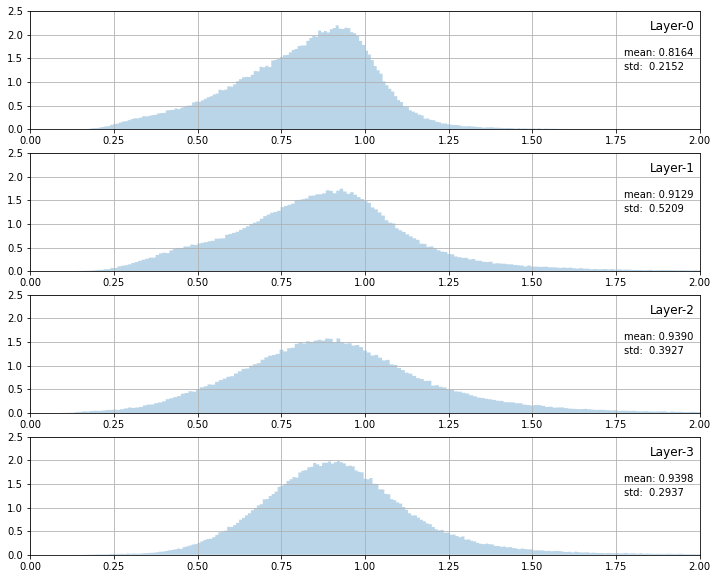

In [49]:
plt.figure(figsize=(12, 10))

np.random.seed(1234)
size = 1000
rand_idx = np.random.choice(weight_std.shape[0], size=size, replace=False)

utts_weight_std = weight_std[rand_idx]

for i in range(4):
    # print(i, weight_std[:,i].mean())
    plt.subplot(4, 1, i+1)
    ws = utts_weight_std[:,i].reshape(-1)
    
    plt.hist(ws, density=True,
             bins='auto', histtype='stepfilled', alpha=0.3)
    plt.xlim([0, 2])
    plt.ylim([0, 2.5])
    plt.grid()
    # plt.title('Layer-{} mean: {:.4f} std: {:.4f}'.format(i, ws.mean(), ws.std()))
    # plt.title('Layer-{} mean: {:.4f} std: {:.4f}'.format(i, ws.mean(), ws.std()))
    plt.text(1.85, 2.1, 'Layer-{}'.format(i, ws.mean(), ws.std()), fontsize=12)
    plt.text(1.775, 1.55,'mean:{:>7.4f}'.format(ws.mean()))
    plt.text(1.775, 1.25,'std:{:>8.4f}'.format(ws.std()))
    # print(/)
    
# plt.legend(np.arange(4))
plt.savefig('imgs/ecapa_v1_{}_layer_std_shift.png'.format(size))

In [48]:
'mean:{:>7.4f}'.format(0.1)

'mean: 0.1000'

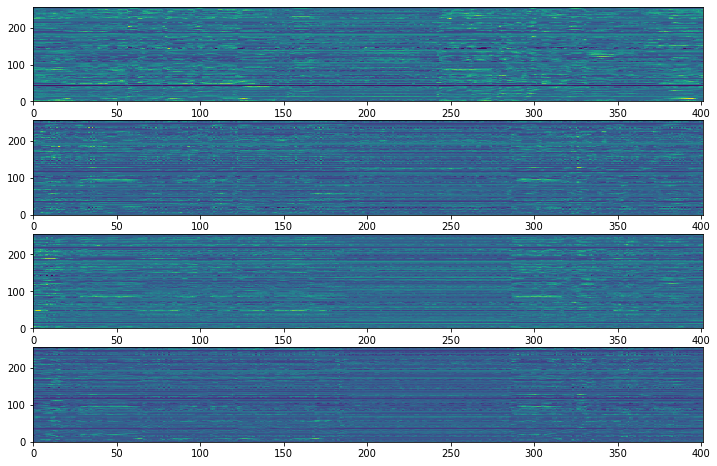

In [207]:
plt.figure(figsize=(12, 2*len(audios)))
for i in range(len(audios)):
    plt.subplot(len(audios),1,i+1)
    plt.pcolormesh(x1s[i].squeeze())

In [232]:
x1s.shape

torch.Size([4, 4, 256, 401])

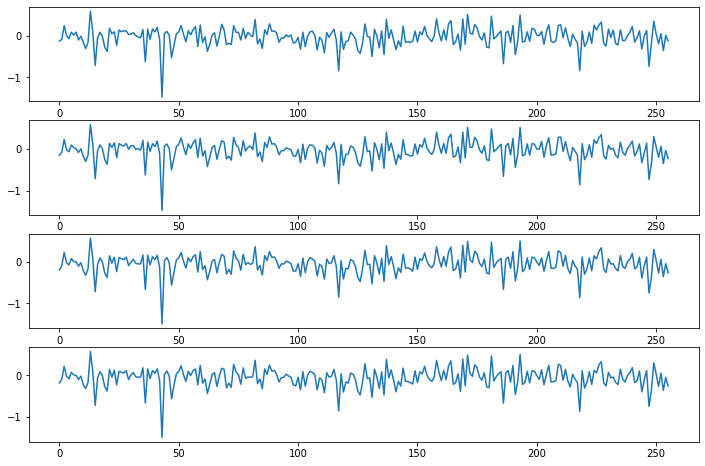

In [246]:
plt.figure(figsize=(12, 2*len(audios)))
# for i in range(len(audios)):
#     plt.subplot(len(audios),1,i+1)
#     plt.plot(x1s[i].squeeze().mean(dim=1))
    
for i in range(len(audios)):
    plt.subplot(len(audios),1,i+1)
    plt.plot(x1s[:, i].squeeze().mean(dim=2).mean(dim=0))

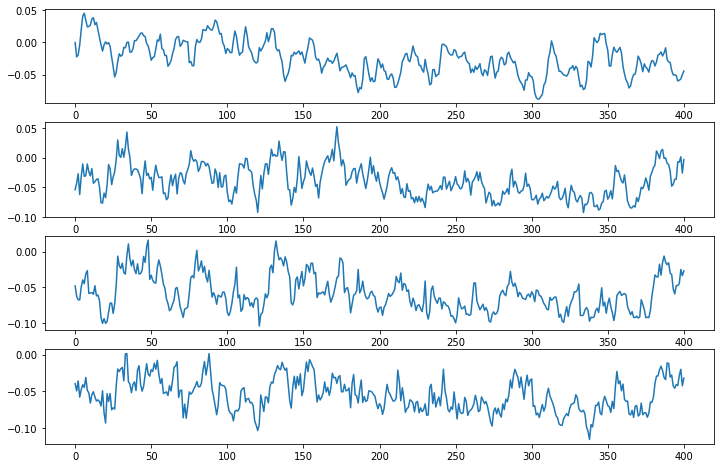

In [247]:
plt.figure(figsize=(12, 2*len(audios)))
# for i in range(len(audios)):
#     plt.subplot(len(audios),1,i+1)
#     plt.plot(x1s[i].squeeze().mean(dim=0))

for i in range(len(audios)):
    plt.subplot(len(audios),1,i+1)
    plt.plot(x1s[:, i].squeeze().mean(dim=1).mean(dim=0))

#### frequency weights

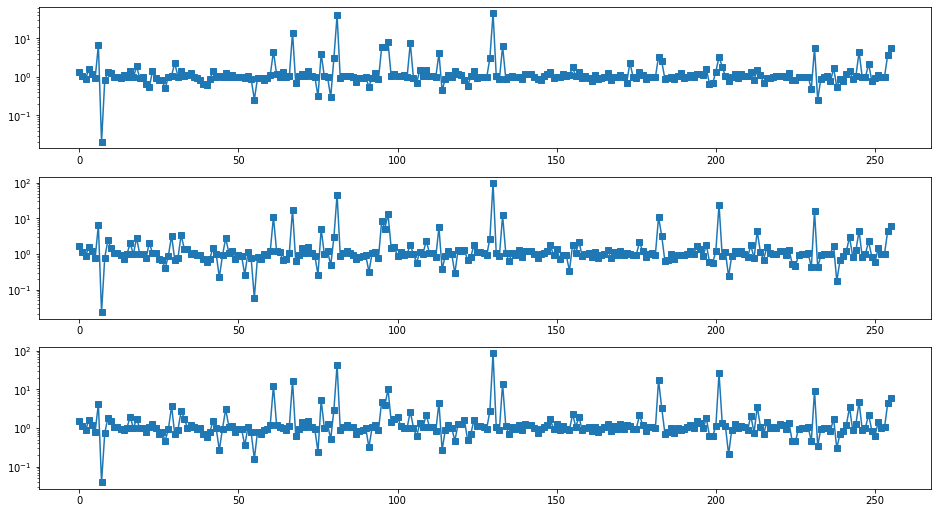

In [248]:
# plt.figure(figsize=(12, 6))
# plt.plot(x1s[1].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs(), marker='s')
# plt.plot(x1s[1].squeeze().mean(dim=1)/x1s[0].squeeze().mean(dim=1))
plt.figure(figsize=(16, 4*(len(audios)-1)))

# for i in range(1, len(audios)):
#     plt.subplot(len(audios),1,i+1)
#     weight = x1s[i].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs()
    
#     plt.plot(weight, marker='s）
#     plt.yscale('log')
             
for i in range(1, len(audios)):
    plt.subplot(len(audios),1,i+1)
    weight = x1s[:, i].squeeze().mean(dim=2).abs()/x1s[:, 0].squeeze().mean(dim=2).abs()
    weight = weight.mean(dim=0)
    plt.plot(weight, marker='s')
    plt.yscale('log')

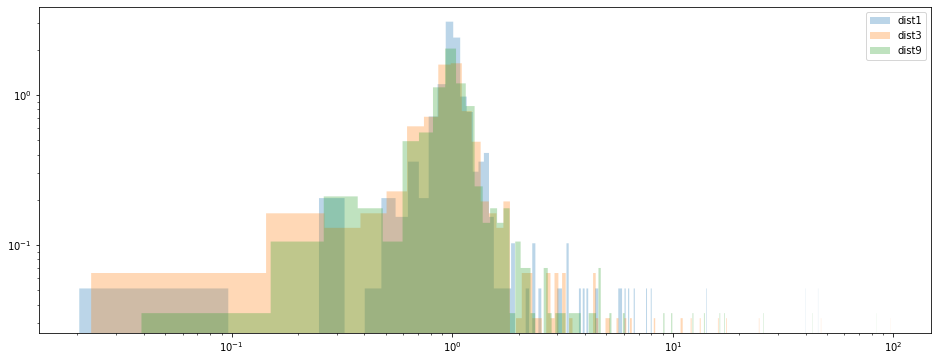

In [241]:
# plt.figure(figsize=(12, 6))
# plt.plot(x1s[1].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs(), marker='s')
# plt.plot(x1s[1].squeeze().mean(dim=1)/x1s[0].squeeze().mean(dim=1))
plt.figure(figsize=(16, 6))

# for i in range(1, len(audios)):
#     # plt.subplot(len(audios),1,i+1)
#     weight = x1s[i].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs()
#     plt.hist(weight, density=True, bins='auto', histtype='stepfilled', alpha=0.3)
    
for i in range(1, len(audios)):
    # plt.subplot(len(audios),1,i+1)
    weight = x1s[:, i].squeeze().mean(dim=2).abs()/x1s[:, 0].squeeze().mean(dim=2).abs()
    weight = weight.mean(dim=0)
    plt.hist(weight, density=True, bins='auto', histtype='stepfilled', alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.legend(['dist1', 'dist3', 'dist9',])

#### time weights

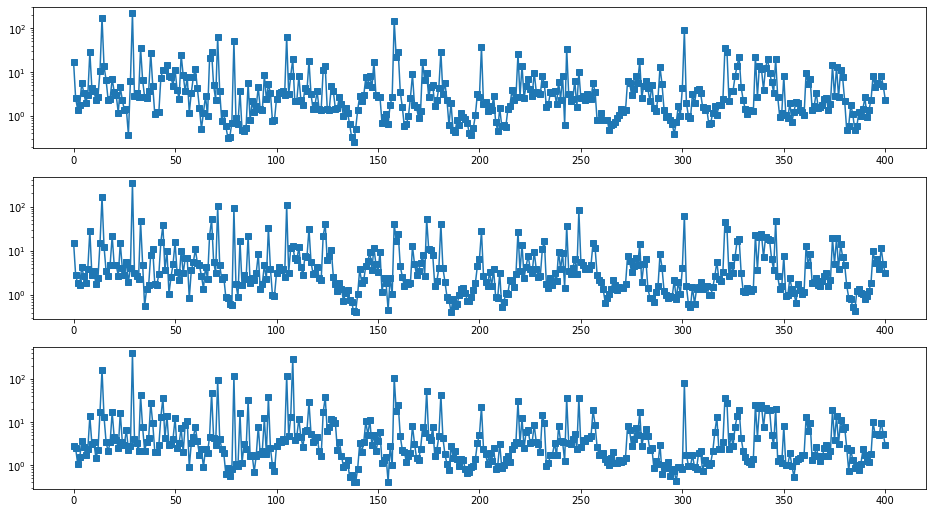

In [242]:
plt.figure(figsize=(16, 4*(len(audios)-1)))

for i in range(1, len(audios)):
    plt.subplot(len(audios),1,i+1)
    # plt.plot(x1s[i].squeeze().mean(dim=0).abs()/x1s[0].squeeze().mean(dim=0).abs(),
    #          marker='s')
    weight = x1s[:, i].squeeze().mean(dim=1).abs()/x1s[:, 0].squeeze().mean(dim=1).abs()
    weight = weight.mean(dim=0)
    plt.plot(weight, marker='s')
    
    plt.yscale('log')

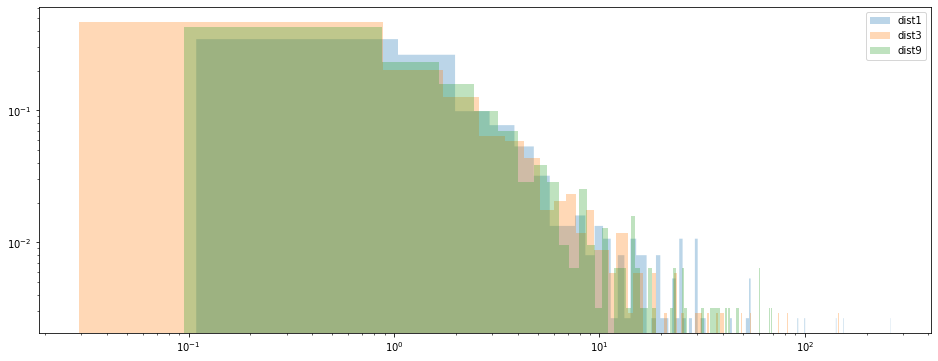

In [243]:
# plt.figure(figsize=(12, 6))
# plt.plot(x1s[1].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs(), marker='s')
# plt.plot(x1s[1].squeeze().mean(dim=1)/x1s[0].squeeze().mean(dim=1))
plt.figure(figsize=(16, 6))

for i in range(1, len(audios)):
    # plt.subplot(len(audios),1,i+1)
    # weight = x1s[i].squeeze().mean(dim=0).abs()/x1s[0].squeeze().mean(dim=0).abs()
    weight = x1s[i].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs()
    weight = weight.mean(dim=0)
    plt.hist(weight, density=True, bins='auto', histtype='stepfilled', alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.legend(['dist1', 'dist3', 'dist9',])

#### Fit weights

In [ ]:
f = Fitter(weights.numpy())  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [330]:
x1s.shape

torch.Size([4, 4, 256, 401])

In [ ]:
weight = x1s[:, 1].squeeze().mean(dim=2).abs()/x1s[:, 0].squeeze().mean(dim=2).abs()
weight = weight.mean(dim=0)

f = Fitter(weights.numpy())  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

2024-02-08 22:12:17.366 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-02-08 22:12:17.967 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.000128)
2024-02-08 22:12:18.979 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED kstwo distribution (taking more than 30 seconds)
2024-02-08 22:12:19.443 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED rv_continuous distribution (taking more than 30 seconds)
2024-02-08 22:12:19.532 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED rv_histogram distribution (taking more than 30 seconds)
2024-02-08 22:12:19.896 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.00013)
2024-02-08 22:12:20.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1.9e-05)
2024-02-08 22:12:22.318 | WARNING  | fitter.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.000019,274617.630467,274633.931162,inf,0.453002,0.0
gumbel_r,0.000104,27115.526653,27131.827348,inf,0.565760,0.0
gumbel_l,0.000117,40779.582911,40795.883607,inf,0.567582,0.0
rayleigh,0.000124,1994.832369,2011.133064,inf,0.622670,0.0
uniform,0.000128,1765.778466,1782.079161,inf,0.664168,0.0


/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


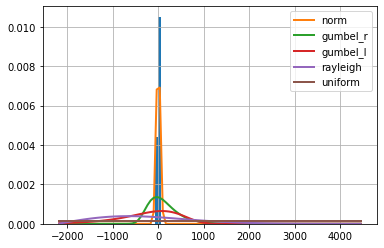

In [51]:
# weight = x1s[:, 1].squeeze().mean(dim=2).abs()/x1s[:, 0].squeeze().mean(dim=2).abs()
# weight = (x1s[:, 1].squeeze()/x1s[:, 0].squeeze()).mean(dim=2)
# weight = weight.mean(dim=0)
f = Fitter(weight.numpy())  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [52]:
f.fitted_param['norm']

(1.2177782, 42.858753)

/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [60]:
weight.numpy().std()

42.858753

In [54]:
from scipy.stats import genhyperbolic, norm

In [61]:
r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)

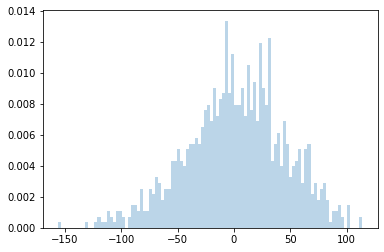

In [64]:
_ = plt.hist(r,
               density=True,
               bins=100, histtype='stepfilled', alpha=0.3)

2024-02-08 18:30:58.248 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genhyperbolic distribution with error=2.8e-05)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,0.000028,1903.542559,1928.081335,inf,0.01376,0.990204


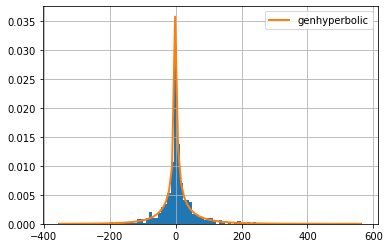

In [342]:
f = Fitter(r, distributions=['genhyperbolic'])  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [343]:
f.fitted_param['genhyperbolic']

(0.21714127270091094,
 0.010832818637862814,
 0.0008963743018679776,
 0.07181182908022424,
 0.847805064350712)

In [371]:
# mean, var, skew, kurt =
genhyperbolic.stats(0.01, 0.847805064350712, 0.0008963743018679776, moments='mvsk')

(0.0015962998669741182,
 1.780843321945129,
 0.003648838904626016,
 3.050388881854828)

In [340]:
weight.reshape(-1).shape

torch.Size([1024])

In [363]:
genhyperbolic.stats(0, 1.25, 0.000805, moments='mvsk')

(0.0008701790514267727,
 1.0809683199050004,
 0.001837550604807425,
 2.1955228009712346)

In [348]:
weight.reshape(-1).mean()

tensor(0.3350)

In [369]:
r = genhyperbolic.rvs(0.01, 0.847805064350712, 0.0008963743018679776, size=1024)

In [121]:
weight.shape

torch.Size([100, 256])

(0.0, 0.5)

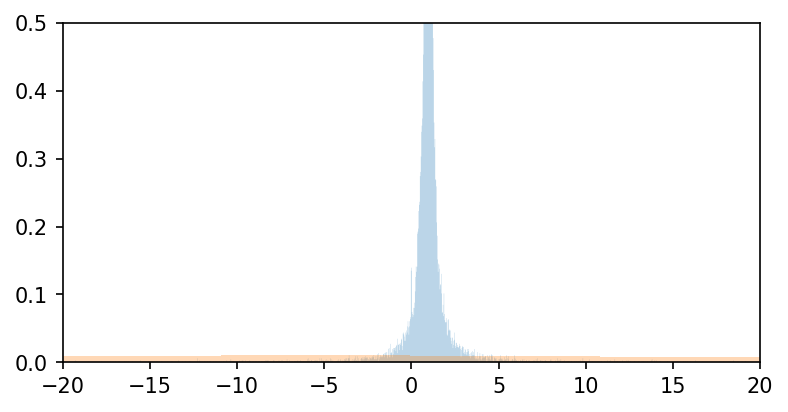

In [56]:
fig = plt.figure(figsize=(6, 3), dpi=150)

# _ = plt.hist(weight.reshape(-1))
_ = plt.hist(weight.reshape(-1), density=True, bins='auto', histtype='stepfilled', alpha=0.3)
_ = plt.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-20, 20])
plt.ylim([0, 0.5])

(0.0, 1.0)

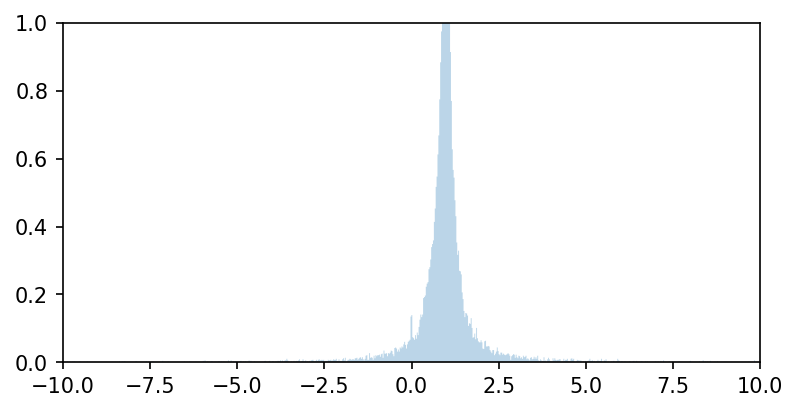

In [127]:
fig = plt.figure(figsize=(6, 3), dpi=150)

# _ = plt.hist(weight.reshape(-1))
_ = plt.hist(weight.reshape(-1), density=True, bins='auto', histtype='stepfilled', alpha=0.3)
# _ = plt.hist(r, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-10, 10])
plt.ylim([0, 2])

In [ ]:
f = Fitter(new_weights)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [160]:
rand_idx = np.random.choice(x1s.shape[0], size=1000, replace=False)
utts = x1s[rand_idx]

weight = utts[:, 1].squeeze().mean(dim=2)/utts[:, 0].squeeze().mean(dim=2)

In [ ]:
new_weights = []
for w in weight.reshape(-1):
    if w.abs() < 10:
        new_weights.append(float(w))
new_weights = np.array(new_weights)

print(weight.reshape(-1).shape, new_weights.shape)

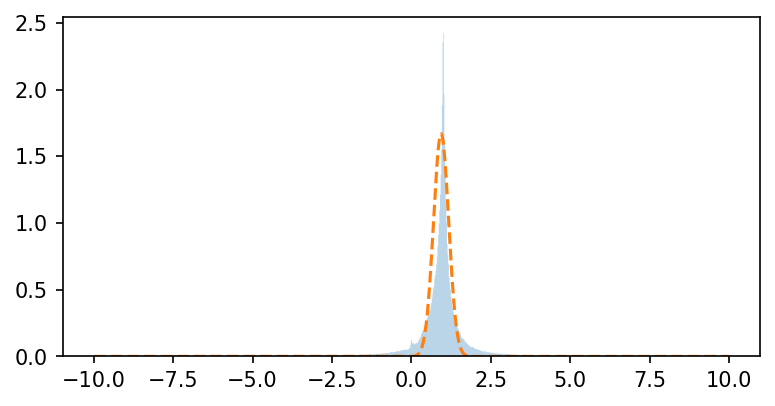

In [162]:
fig = plt.figure(figsize=(6, 3), dpi=150)

# n, bins, patches = plt.hist(weight.reshape(-1), density=True, bins=1000, histtype='stepfilled', alpha=0.3)
n, bins, patches = plt.hist(new_weights, density=True, bins=1000, histtype='stepfilled', alpha=0.3)

mu,sigma = float(np.mean(new_weights)), float(np.std(new_weights))
sigma /= 5
# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
plt.plot(bins, y, '--')
# plt.xlim([-100, 100])
# plt.ylim([0, 2])

In [ ]:
f = Fitter(new_weights, distributions=['cauchy'])  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [ ]:
f.fitted_param['cauchy']

In [143]:
print(len(bins), weight.reshape(-1).shape)

259620 torch.Size([25600])


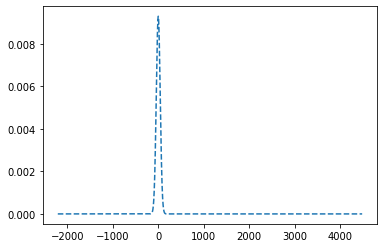

In [140]:
plt.plot(bins, y, '--')
# plt.xlim([-2, 3])

In [ ]:
rand_idx = np.random.choice(x1s.shape[0], size=100, replace=False)
utts = x1s[rand_idx]

weight = utts[:, 1].squeeze().mean(dim=2)/utts[:, 0].squeeze().mean(dim=2)
fig = plt.figure(figsize=(6, 3), dpi=150)

_ = plt.hist(weight.reshape(-1), density=True, stacked=True, bins='auto', histtype='stepfilled')

rv = norm(loc=1.2177782, scale=42.858753)
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
# r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.xlim([-100, 100])

In [128]:
print(weight.reshape(-1).mean(), weight.reshape(-1).std())

tensor(1.2178) tensor(42.8596)


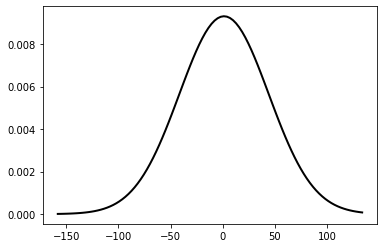

In [131]:
rv = norm(loc=1.2177782, scale=42.858753)
x = np.linspace(rv.ppf(0.0001), rv.ppf(0.9990), 100)
# r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [ ]:
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [31]:
rand_idx

array([1227,  928, 2494, 1811,  197, 1271,  449, 2673, 2401,   91, 2573,
       2556,  862, 2310, 2104, 1520,  153, 1234, 1692, 1409, 1071, 1979,
        374, 2423, 2605,  563, 2062,  476,  968, 1504, 2170,  863,  295,
       1948, 2661, 2694, 1018,  836, 2535, 2072, 1486, 2120,  570,  718,
       2498, 2204, 2136, 1475,  961,  882, 1596, 1704, 1742, 1842,  626,
        807, 1685, 2576, 1662, 1916, 1884, 1790, 1656,   13, 2651, 1049,
       1616,  430, 2357, 1693, 1359, 2253,  673, 2205,  656, 1103, 1970,
       2564, 2378,  127,  137, 1100, 2399,  218,  550,  805, 2720, 2182,
       1783, 1841, 1950, 2071, 2249,   35, 1526, 1602, 1096,  929, 2643,
        770])

2024-01-22 17:34:07.089 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted loglaplace distribution with error=0.006254)
2024-01-22 17:34:07.239 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr12 distribution with error=0.00157)
2024-01-22 17:34:08.082 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted fisk distribution with error=0.00612)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr12,0.001570,2346.344149,2360.524859,inf,0.157109,0.000006
fisk,0.006120,2670.612820,2681.248352,inf,0.144180,0.000042
loglaplace,0.006254,2363.200058,2373.835590,inf,0.104270,0.007070


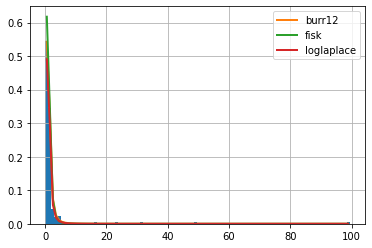

In [110]:
f = Fitter(weights.exp().numpy(), distributions=['burr12', 'fisk', 'loglaplace'],)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
f.summary()  # 输出拟合结果

In [126]:
f.fitted_param['fisk']
# burr12 
# (5.751994036252712,
#  0.4357702081096014,
#  -0.29750528388651315,
#  1.0457976495726833)

# fisk
# (3.0306261007942084, -0.048097168707297466, 1.0519824759414926)

(3.0306261007942084, -0.048097168707297466, 1.0519824759414926)

In [144]:
from scipy.stats import burr12, fisk
import numpy as np

In [ ]:
r = burr12.rvs(c, d, size=1000)

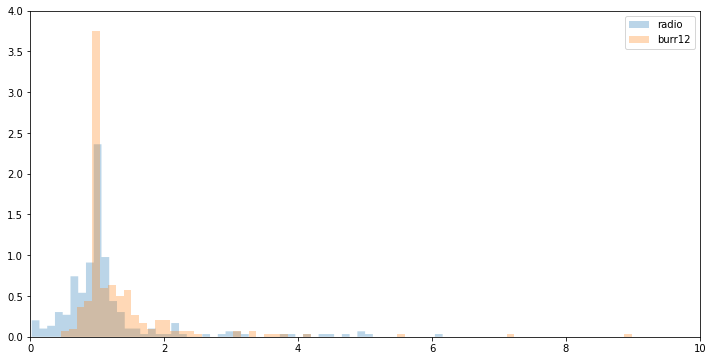

In [325]:
plt.figure(figsize=(12, 6))

_ = plt.hist(weights.exp().numpy(), density=True, bins='auto', histtype='stepfilled', alpha=0.3)

r = burr12.rvs(6, 0.45, size=(96, 256))
ones = torch.bernoulli(torch.ones(r.shape) * 0.3).numpy()
r = np.where(ones == 1, 1, r)
_ = plt.hist(r[0], density=True, bins='auto', histtype='stepfilled', alpha=0.3)

# r = fisk.rvs(3, size=256)
# _ = plt.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.3)

plt.xlim([0, 10])
plt.ylim([0, 4])
plt.legend(['radio', 'burr12', 'fisk'])

In [192]:
torch.tensor(r).unsqueeze(2).shape

torch.Size([96, 256, 1])

tensor(1.6818) tensor(3.9113)
1.4482564242287894 0.8948060179452997


/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


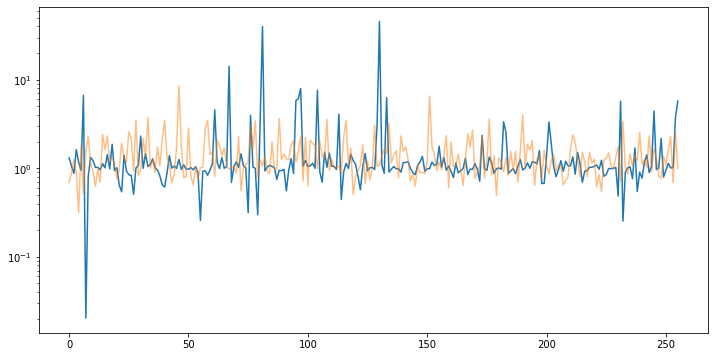

/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [328]:
plt.figure(figsize=(12, 6))
weight = x1s[:, 1].squeeze().mean(dim=2).abs()/x1s[:, 0].squeeze().mean(dim=2).abs()
weight = weight.mean(dim=0)

plt.plot(weight)
print(weight.mean(), weight.std())

r = burr12.rvs(5.7, 0.45, size=256)
# ones = torch.bernoulli(torch.ones(256) * 0.5).numpy()
# r = np.where(ones == 1, 1, r)
print(r.mean(), r.std())

plt.plot(r, alpha=0.5)


# r = burr12.rvs(2, 1, size=256)
# ones = torch.bernoulli(torch.ones(256) * 0.4).numpy()
# r = np.where(ones == 1, 1, r)
# print(r.mean(), r.std())
# plt.plot(r, alpha=0.5)

# plt.plot(np.e**(r-1))
plt.yscale('log')

In [319]:
# for i in range(3, 4):
r = burr12.rvs(6, 0.45, size=1024)
# ones = torch.bernoulli(torch.ones(1024) * 0.4).numpy()
# r = np.where(ones == 1, 1, r)
print(r.mean(), r.std())
    
# tensor(1.6818) tensor(3.9113)
# 1 1 4.392036907591418 18.011505620703893
# 2 1 1.354105701917669 1.818947223280767
# 3 1 1.169970206875718 0.8442384045358392

# 2 1 1.321033789686989 1.163451438274748
# 2 2 0.7963242989021717 0.3947041630640829
# 2 3 0.7441576809348918 0.3814883189429346

1.4381088729511875 0.886374351869809


In [ ]:
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [265]:
print()

In [ ]:
# _=plt.hist(weights.exp().numpy(), density=True, bins='auto', histtype='stepfilled')
plt.xlim([0, 20])
plt.ylim([0, 1.5])

In [43]:
weights = x1s[1].squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs()
weights = weights.log()

(array([  1.,   0.,   1.,   3.,   1.,   3.,   6.,  21.,  72., 109.,  16.,
          8.,   9.,   1.,   0.,   1.,   1.,   1.,   1.,   1.]),
 array([-3.79858279, -3.37870646, -2.95883036, -2.53895402, -2.11907768,
        -1.69920135, -1.27932513, -0.85944885, -0.43957257, -0.0196963 ,
         0.40017998,  0.82005626,  1.23993254,  1.65980887,  2.07968521,
         2.49956131,  2.91943765,  3.33931398,  3.75919008,  4.17906666,
         4.59894276]),
 <BarContainer object of 20 artists>)

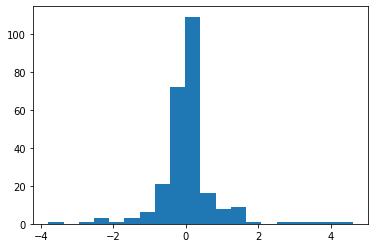

In [45]:
plt.hist(weights, bins=20)

In [46]:
print(weights.mean(), weights.std())

tensor(0.0357) tensor(0.8266)


In [53]:
x1s[0].shape

torch.Size([1, 256, 401])

In [97]:
this_x = x1s[0]

mul_noise = 10 * torch.FloatTensor(this_x.shape).normal_()
# mul_noise = 0.5 * torch.FloatTensor(this_x.mean(dim=2, keepdim=True).shape).normal_()
mul_x = torch.exp(mul_noise.mean(dim=2, keepdim=True)) * this_x
# mul_x = torch.exp(mul_noise) * this_x

In [76]:
mul_noise = 0.8 * torch.FloatTensor(this_x.shape).normal_()
mul_noise.shape

torch.Size([1, 256, 401])

In [63]:
s = this_x.shape

In [65]:
s[2] = 0

TypeError: 'torch.Size' object does not support item assignment

In [62]:
torch.FloatTensor([1, 256, 1]).normal_()

tensor([ 0.0364, -1.4882, -1.5118])

In [52]:
mul_x.shape

torch.Size([1, 1, 64000])

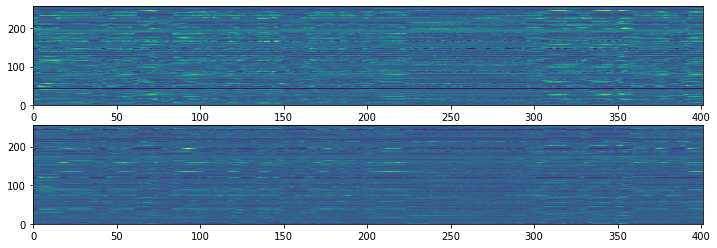

In [98]:
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.pcolormesh(x1s[0].squeeze())

plt.subplot(2,1,2)
plt.pcolormesh(mul_x.squeeze())

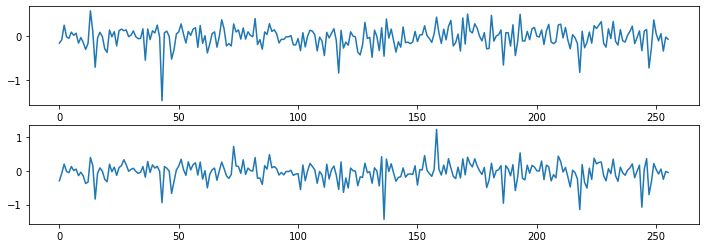

In [99]:
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.plot(x1s[0].squeeze().mean(dim=1))

plt.subplot(2,1,2)
plt.plot(mul_x.squeeze().mean(dim=1))

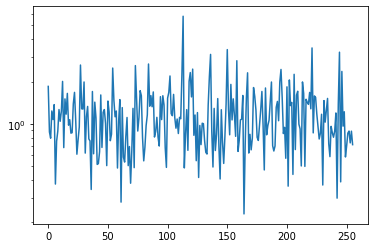

In [100]:
plt.plot(mul_x.squeeze().mean(dim=1).abs()/x1s[0].squeeze().mean(dim=1).abs())
plt.yscale('log')

### Simulated Radio Audios

In [7]:
import pandas as pd
import json
import pickle

In [8]:
v1_json = 'data/vox1.dev.6s.json'

if os.path.isfile(v1_json):
    with open(v1_json, 'r') as f:
        audio_uids = json.load(f)
else:
    audio_uids = []
    with open(os.path.join(lstm_path, 'data/vox1/dev/wav.scp'), 'r') as f:
        for l in tqdm(f.readlines(), ncols=50):
            uid, upath = l.split()
            wav,sr = sf.read(upath)
            dur = float(len(wav)/sr)

            if dur >= 6:
                uid_path = '/'.join(upath.split('/')[-3:])[:-4]
                audio_uids.append(uid_path)
                
    with open(v1_json, 'w') as f:
        json.dump(audio_uids, f)

In [12]:
# uid = 'id10270/5r0dWxy17C8/00001'
audios = []
for uid in tqdm(audio_uids, ncols=50):
    # /home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav/wav_nb_radsnr1/id10001/1zcIwhmdeo4/00001.wav
    upath = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav/wav/{}.wav'.format(uid)
    upath_radio = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav/wav_nb_radsnr1/{}.wav'.format(uid)
    paths = [upath, upath_radio]
    
    this_audio = [torch.tensor(read_WaveInt(paths[0],
                                  start=20000, stop=52000)).reshape(1,1,-1)]
    for u in paths[1:]:
        this_audio.append(torch.tensor(read_WaveInt(u,
                                  start=16000, stop=48000)).reshape(1,1,-1))

#     plt.figure(figsize=(12, 4))
#     plt.plot(this_audio[0].squeeze(), alpha=0.6)
#     plt.plot(this_audio[1].squeeze(), alpha=0.6)
#     IPython.display.Audio(y, rate=sr)
#     break
    audios.append(torch.cat(this_audio, dim=0))
    
x1s = []
with torch.no_grad():
    for x in tqdm(audios, ncols=50):
        fb_x = model.input_mask(x)
        if len(fb_x.shape) == 4:
            fb_x = fb_x.squeeze(1).float()
        fb_x = fb_x.transpose(1, 2)

        x1 = model.blocks[0](fb_x)
        x1s.append(x1)
        
x1s = torch.stack(x1s)

100%|█████| 84268/84268 [00:48<00:00, 1746.45it/s]


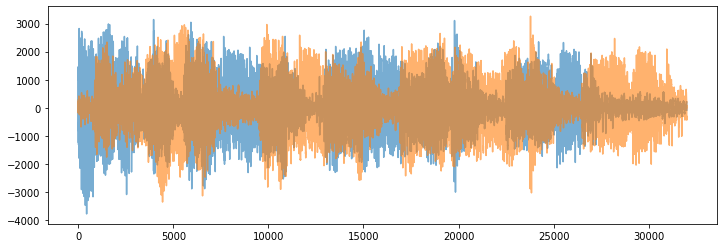

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(this_audio[0].squeeze(), alpha=0.6)
plt.plot(this_audio[1].squeeze(), alpha=0.6)

In [19]:
sr = 16000
IPython.display.display(IPython.display.Audio(this_audio[0].squeeze(), rate=sr))
IPython.display.display(IPython.display.Audio(this_audio[1].squeeze(), rate=sr))

In [89]:
audios[0].shape

torch.Size([2, 1, 64000])

In [7]:
v1_feat = 'data/vox1.dev.6s.pickle'

if os.path.isfile(v1_feat):
    with open(v1_feat, 'rb') as f:
        x1s = pickle.load(f)
else:
    with open(v1_feat, 'wb') as f:
        pickle.dump(x1s, f)

In [8]:
x1s.shape

torch.Size([84268, 2, 256, 201])

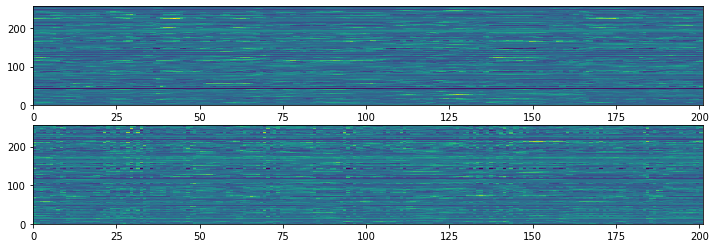

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.pcolormesh(x1s[0][0].squeeze())

plt.subplot(2,1,2)
plt.pcolormesh(x1s[0][1].squeeze())

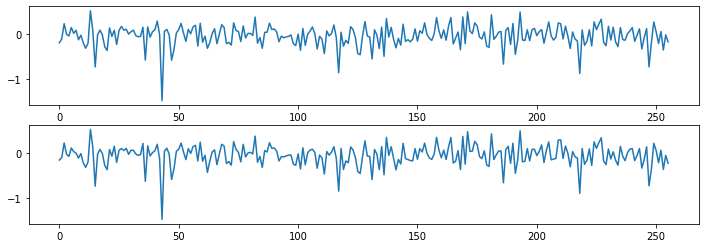

In [95]:
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1)
plt.plot(x1s[0][0].squeeze().mean(dim=1))

plt.subplot(2,1,2)
plt.plot(x1s[0][1].squeeze().mean(dim=1))

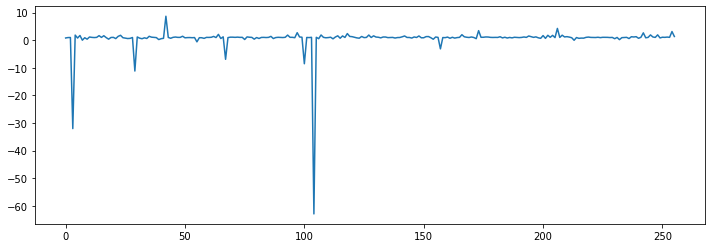

In [96]:
plt.figure(figsize=(12, 4))
# plt.subplot(2,1,1)
plt.plot(x1s[0][1].squeeze().mean(dim=1)/x1s[0][0].squeeze().mean(dim=1))

# plt.subplot(2,1,2)
# plt.plot(x1s[0][1].squeeze().mean(dim=1))

In [97]:
all_weights = x1s[:, 1].squeeze().mean(dim=2)/x1s[:, 0].squeeze().mean(dim=2)

In [98]:
all_weights.shape

torch.Size([84268, 256])

(-1.0, 3.0)

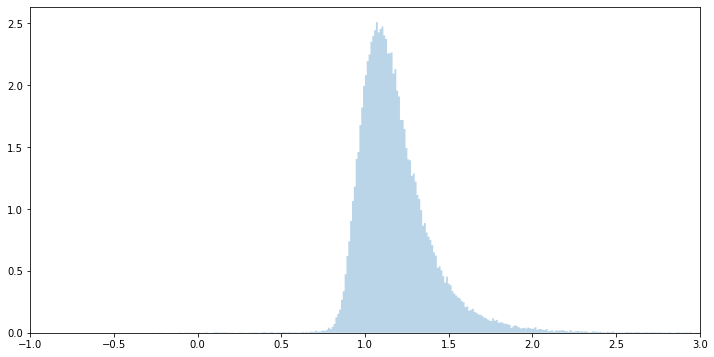

In [114]:
plt.figure(figsize=(12, 6))

plt.hist(all_weights[:, 1], density=True, bins='auto', histtype='stepfilled', alpha=0.3)

plt.xlim([-1, 3])

(-30.0, 30.0)

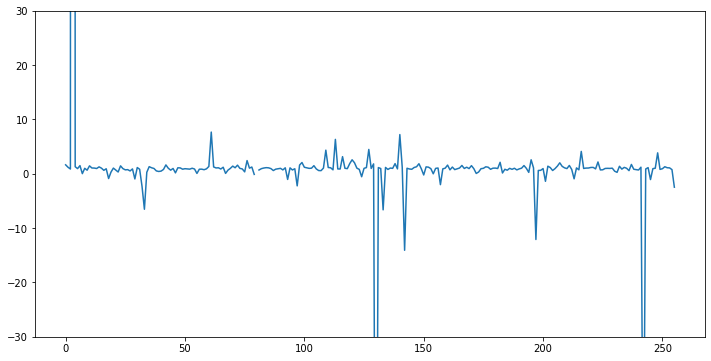

In [111]:
plt.figure(figsize=(12, 6))

plt.plot(all_weights.mean(dim=0))
# plt.yscale('log')
plt.ylim([-30, 30])

In [115]:
all_weights = (x1s[:, 1].squeeze()/x1s[:, 0].squeeze()).mean(dim=2)

(-10.0, 10.0)

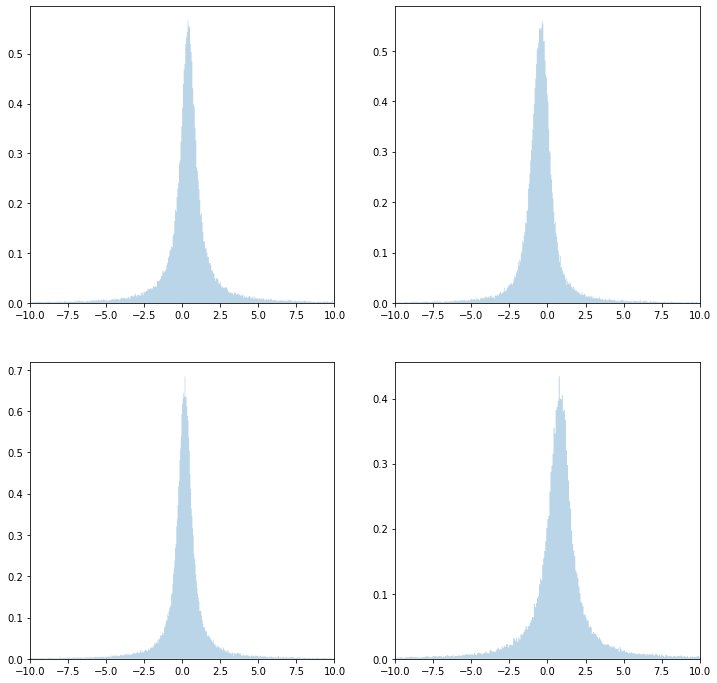

In [120]:
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.hist(all_weights[:, 1], density=True, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-10, 10])

plt.subplot(2,2,2)
plt.hist(all_weights[:, 21], density=True, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-10, 10])

plt.subplot(2,2,3)
plt.hist(all_weights[:, 121], density=True, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-10, 10])

plt.subplot(2,2,4)
plt.hist(all_weights[:, 221], density=True, bins='auto', histtype='stepfilled', alpha=0.3)
plt.xlim([-10, 10])

(-30.0, 30.0)

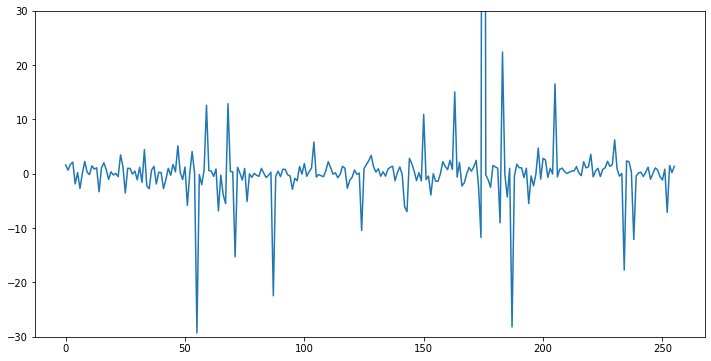

In [116]:
plt.figure(figsize=(12, 6))

plt.plot(all_weights.mean(dim=0))
# plt.yscale('log')
plt.ylim([-30, 30])

#### Fit weights

In [10]:
np.random.seed(1234)
rand_idx = np.random.choice(x1s.shape[0], size=1000, replace=False)
utts = x1s[rand_idx]

# averaged along with time
# frequency
# weight = utts[:, 1].squeeze().mean(dim=2)/utts[:, 0].squeeze().mean(dim=2)
# weight_mean = utts[:, 1].squeeze().mean(dim=2) - utts[:, 0].squeeze().mean(dim=2)
# weight_std = utts[:, 1].squeeze().std(dim=2) / utts[:, 0].squeeze().std(dim=2)

# time
weight_mean = utts[:, 1, 0].squeeze() - utts[:, 0, 0].squeeze()
weight_std    = (utts[:, 1, 0].squeeze() - utts[:, 1, 0].squeeze().mean(dim=-1, keepdim=True)) / (utts[:, 0, 0].squeeze() -utts[:, 0, 0].squeeze().mean(dim=-1, keepdim=True))

In [ ]:
weight_std.shape

In [ ]:
# weight = weight_mean
weight = weight_std
new_weights = []
for w in weight.reshape(-1):
    # if w.abs() < 10:
    new_weights.append(float(w))
new_weights = np.array(new_weights)

print(weight.reshape(-1).shape, new_weights.shape)


KeyboardInterrupt



In [ ]:
# f = Fitter(new_weights, distributions=['cauchy'])  # 创建Fitter类
f = Fitter(new_weights)  # 创建Fitter类
f.fit()                           # 调用fit函数拟合分布
f.summary()                 # 输出拟合结果

In [13]:
f.fitted_param['laplace']

# mean cauchy
# (0.9797403468669471, 0.19201643794391055)

# mean_shift cauchy
# (-0.015355636647630101, 0.021336196535428266)

# std_shift logistic
# 500 (0.8449707596740228, 0.1357335289099121)
# 100 (0.8428678203971093, 0.13537117337743185)

# logistic	0.521887	714.981874	731.282570	inf	0.014393	4.902051e-05
# norm	0.700077	1187.626241	1203.926937	inf	0.038136	8.726614e-33
# hypsecant	0.927808	640.289535	656.590230	inf	0.023220	2.016203e-12
# gumbel_r	3.076798	508.022423	524.323118	inf	0.059596	1.765824e-79
# laplace	3.322758	577.231096	593.531791	inf	0.044512	1.630328e-44

# mean shift
# laplace (0.0, 0.3371028874262351)
# laplace	3.261310	1020.393069	1040.815189	inf	0.081313	0.0
# logistic	4.312217	1205.864682	1226.286803	inf	0.094649	0.0
# norm	4.786921	2174.269666	2194.691787	inf	0.111707	0.0
# gumbel_l	5.638422	25658.109217	25678.531337	inf	0.115513	0.0
# gumbel_r	6.384316	1279.881440	1300.303560	inf	0.138520	0.0

(0.0, 0.3371028874262351)

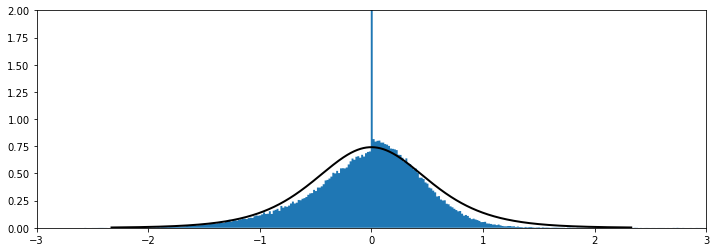

In [38]:
plt.figure(figsize=(12, 4))

n, bins,patches = plt.hist(new_weights, density=True, stacked=True, bins='auto', histtype='stepfilled')

# rv = stats.cauchy(0.98, 0.192)
# rv = stats.logistic(0.842, 0.135)
# rv = stats.cauchy(-0.0164775, 0.021582)
rv = stats.logistic(0, 0.3371028874262351)
x  = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 2000)
# r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.xlim([-3, 3])
plt.ylim([0, 2])

plt.savefig('imgs/ecapa_v1_1000_time_mean_shift.png')

In [33]:
np.random.uniform(0,1)

0.33335276047818985

In [39]:
np.argmax(n)

149

In [40]:
len(n),len(bins)

(402, 403)

In [42]:
bins[149], bins[150]

(-0.005321021696821582, 0.011908175340339167)

In [45]:
(bins[149] - bins[150])*n[149]

-0.1621194029850746

In [46]:
np.sum(np.abs(new_weights) < 0.01) / len(new_weights)

0.1638905472636816

In [48]:
(bins[149] - bins[150]) * (rv.pdf(bins[149]) + rv.pdf(bins[149]))/2

-0.01277660660163199

In [59]:
1 - 0.01277 / 0.163890547

0.9220821442496009

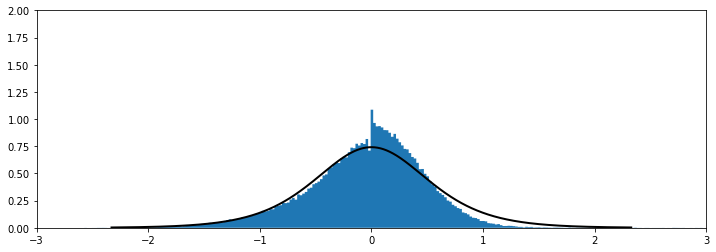

In [61]:
plt.figure(figsize=(12, 4))

other_weights = []
for i in new_weights:
    if np.abs(i) < 0.01:
        if np.random.uniform(0,1) < 0.9:
            continue
    other_weights.append(i)

other_weights = np.array(other_weights)
n, bins,patches = plt.hist(other_weights, density=True, stacked=True, bins='auto', histtype='stepfilled')
rv = stats.logistic(0, 0.3371028874262351)
x  = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 2000)
# r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.xlim([-3, 3])
plt.ylim([0, 2])

plt.savefig('imgs/ecapa_v1_1000_time_mean_shift_dp09real.png')

In [23]:
weight.shape

torch.Size([1000, 256])

In [16]:
noise_mean = utts[:, 1].squeeze().mean(dim=2)
original_mean = utts[:, 0].squeeze().mean(dim=2)

noise_std = utts[:, 1].squeeze().std(dim=2)
original_std = utts[:, 0].squeeze().std(dim=2)

In [17]:
mean_shift = original_mean - noise_mean 
std_shift = noise_std / original_std

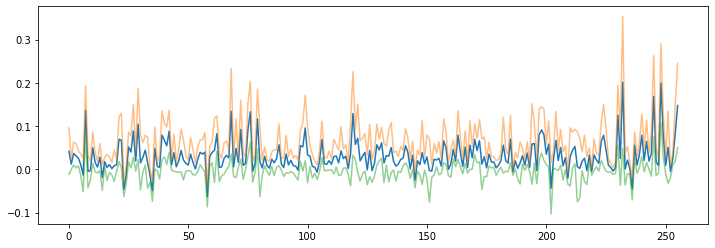

In [20]:
plt.figure(figsize=(12, 4))

plt.plot(mean_shift.mean(dim=0))

plt.plot(mean_shift.mean(dim=0) + mean_shift.std(dim=0), alpha=0.5, color='b')
plt.plot(mean_shift.mean(dim=0) - mean_shift.std(dim=0), alpha=0.5, color='b')

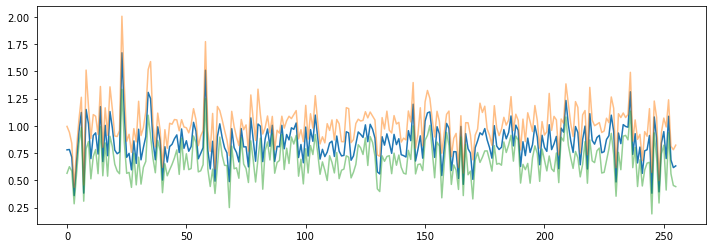

In [21]:
plt.figure(figsize=(12, 4))

plt.plot(std_shift.mean(dim=0))

plt.plot(std_shift.mean(dim=0) + std_shift.std(dim=0), alpha=0.5, color='b')
plt.plot(std_shift.mean(dim=0) - std_shift.std(dim=0), alpha=0.5, color='b')

#### Fit weight time

In [24]:
rand_idx = np.random.choice(x1s.shape[0], size=500, replace=False)
utts = x1s[rand_idx]

weight = utts[:, 1].squeeze().mean(dim=1)/utts[:, 0].squeeze().mean(dim=1)

In [ ]:
new_weights = []
for w in weight.reshape(-1):
    if w.abs() < 10:
        new_weights.append(float(w))
new_weights = np.array(new_weights)

print(weight.reshape(-1).shape, new_weights.shape)


KeyboardInterrupt



In [ ]:
plt.figure(figsize=(12, 4))

_ = plt.hist(new_weights, density=True, stacked=True, bins='auto', histtype='stepfilled')

# rv = stats.cauchy(0.98, 0.192)
# x  = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 2000)
# # r = norm.rvs(loc=1.2177782, scale=42.858753, size=1024)
# plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.xlim([-1, 3])